In [3]:
from dasi import LibraryDesign, Design
from pyblast.utils import make_linear, make_circular, load_fasta_glob, load_genbank_glob
import warnings
from Bio import BiopythonParserWarning
from matplotlib import MatplotlibDeprecationWarning
from dasi.constants import Constants
import os
from dasi import logger
from dasi.cost import SpanCost

here = '.'
do_load = True
do_save = True

def get_span_cost():
    """Saves the span cost as bytes; reloads when called."""
    path = os.path.join(here, "span_cost.b")
    if do_load and os.path.isfile(path):
        with logger.timeit("INFO", "loading bytes"):
            print("Loading file: {}".format(path))
            span_cost = SpanCost.load(path)
    else:
        span_cost = SpanCost.open()
        if do_save:
            with logger.timeit("INFO", "saving bytes"):
                print("Saving file: {}".format(path))
                span_cost.dump(path)
    return span_cost

span_cost = get_span_cost()

warnings.simplefilter("ignore", BiopythonParserWarning)
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)

templates = make_circular(load_genbank_glob("../tests/data/test_data/genbank/templates/*.gb"))
registry = make_circular(load_genbank_glob("../tests/data/test_data/genbank/benchling_registry/*.gb"))
primers = make_linear(load_fasta_glob('../tests/data/test_data/primers/primers.fasta'))
queries = make_circular(load_genbank_glob('../tests/data/test_data/genbank/designs/*.gb'))

assert templates
assert registry
assert primers
assert queries

design = LibraryDesign(span_cost)
design.n_jobs = 1
design.add_templates(registry)
design.add_primers(primers)
design.add_queries(queries)
design.add_fragments([])

# regular stuff
design._blast()

# library stuff
design._share_query_blast()

# copied_alignments = container.copy_groups(original_shared_fragments, Constants.SYNTHESIZED_FRAGMENT)
# container.add_alignments(copied_alignments, lim_size=True)


# design._check_shared_repeats()

# design.assemble_graphs(n_jobs=n_jobs)
# design.post_process_library_graphs()

Loading file: ./span_cost.b


In [9]:
span_cost(1200, (0, 0)).data

{'span': array([1200]),
 'cost': array([393.82716049]),
 'efficiency': array([0.81]),
 'material': array([249.]),
 'left_ext': array([nan]),
 'right_ext': array([nan]),
 'time': array([70.]),
 'gene_cost': array([249.]),
 'gene_efficiency': array([1.]),
 'gene_material': array([249.]),
 'gene_size': array([1260.]),
 'gene_time': array([70.]),
 'lprimer_cost': array([0.]),
 'lprimer_efficiency': array([0.9]),
 'lprimer_left_ext': array([0.]),
 'lprimer_material': array([0.]),
 'lprimer_right_ext': array([0.]),
 'lprimer_span': array([-30.]),
 'lprimer_time': array([0.]),
 'lshift': array([-30.]),
 'rprimer_cost': array([0.]),
 'rprimer_efficiency': array([0.9]),
 'rprimer_left_ext': array([0.]),
 'rprimer_material': array([0.]),
 'rprimer_right_ext': array([0.]),
 'rprimer_span': array([-30.]),
 'rprimer_time': array([0.])}

In [2]:
from dasi.models import AlignmentContainer
from dasi.utils import sort_with_keys
from dasi.utils import Region

def overlapping_groups(group_list_a, group_list_b):
    """Get all groups in group_list_b that right-hand overlap with group_list_a"""
    group_sort, group_keys = sort_with_keys(
            group_list_b, key=lambda x: x.query_region.a
        )
    tuples = []
    for group_a in group_list_a:
        alignments = []
        overlapping = AlignmentContainer.filter_alignments_by_span(
                group_sort,
                group_a.query_region,
                key=lambda p: p.query_region.a,
                end_inclusive=False,
            )
        if group_a in overlapping:
            overlapping.remove(group_a)
        tuples.append((group_a, overlapping))
    return tuples

# list of all alignment groups
all_groups = []
for container in design.container_factory.containers().values():
    all_groups += container.get_groups_by_types(Constants.SHARED_FRAGMENT)

# alignment_groups grouped by query_key
grouped_by_qk = {}
for g in all_groups:
    grouped_by_qk.setdefault(g.query_key, list())
    grouped_by_qk[g.query_key].append(g)

# overlapping_by_qk
overlapping = []
for qk, groups in list(grouped_by_qk.items())[:]:
    overlapping += overlapping_groups(groups, groups)

new_alignments = []
for group_a, group_list in overlapping:
    new = container.expand_overlaps(group_list + [group_a], include_left=False, atype=Constants.SHARED_FRAGMENT)
    new_alignments += new

design.container_factory.add_alignments(new_alignments)

AttributeError: 'tuple' object has no attribute 'eq_hash'

In [4]:
import networkx as nx
from copy import deepcopy

def to_undirected(graph):
    """.to_undirected is implemented in networkx out of the box, however, it
    suffers from occational infinite recursion errors during the deepcopy phase
    of the method (unknown as to why)."""
    undirected = nx.Graph()
    copied = deepcopy(graph)
    for n in copied.nodes:
        ndata = copied.nodes[n]
        undirected.add_node(n, **ndata)
    for n1, n2 in copied.edges:
        edata = copied.edges[n1, n2]
        undirected.add_edge(n1, n2, **edata)
    return undirected

def get_subgraphs(graph):
    """Get independent subgraphs."""
    node_list = list(graph.nodes)
    subgraphs = []
    while len(node_list) > 0:
        node = node_list[-1]
        subgraph = nx.bfs_tree(to_undirected(graph), node)
        for n in subgraph.nodes:
            node_list.remove(n)
        subgraphs.append(graph.subgraph(subgraph.nodes))
    return subgraphs


interaction_graph = nx.Graph()

for g in all_groups:
    for a in g.alignments:
        n1 = (a.query_key, a.query_region.a, a.query_region.b)
        n2 = (a.subject_key, a.subject_region.a, a.subject_region.b)
        interaction_graph.add_edge(n1, n2, alignment=a)
graphs = sorted(get_subgraphs(interaction_graph), key=lambda x: x.number_of_nodes())

graph = graphs[-2]

def has_repeats(g):
    """Check if the interaction graph has a repeated DNA sequence"""
    grouped_by_key = {}
    for n in g.nodes:
        grouped_by_key.setdefault(n[0], list())
        grouped_by_key[n[0]].append((n[1], n[2]))
    for k, v in grouped_by_key.items():
        if len(v) > 1:
            print(grouped_by_key)
            return True
    return False
        
nx.draw(graph, node_size=25)

# clusters have 
clusters = []

for g in graphs:
    if not has_repeats(g):
        alignments = []
        for n1, n2, edata in g.edges(data=True):
            alignments.append(edata['alignment'])
        clusters.append(alignments)

qk_to_cluster_indices = {}
for i, c in enumerate(clusters):
    for alignment in c:
        qk_to_cluster_indices.setdefault(alignment.query_key, (alignment, list()))
        qk_to_cluster_indices[alignment.query_key][1].append(i)

for qk, container in design.container_factory.containers().items():
    alignment, cluster = qk_to_cluster_indices[qk]
#     graph = design.graphs[qk]
#     container.filter_alignments_by_span

IndexError: list index out of range

In [ ]:
design.compile()

In [ ]:
design.graphs

In [ ]:
design.seqdb['2bf55dde-2d75-4e56-b6ce-eb09479d461e'][734:811]

In [ ]:
all_keys = dict()
for g in all_groups:
    keys = [g.query_key] + g.subject_keys
    keys.sort()
    gkey = tuple(keys)
    all_keys.setdefault(gkey, list())
    all_keys[gkey].append(g)
    
print(len(all_groups))
print(len(all_keys))

all_keys

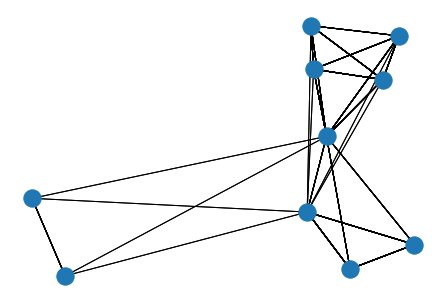

In [6]:
import networkx as nx
%matplotlib inline

blast = design.blast_factory('queries', 'queries')

blast.quick_blastn()
results = blast.get_perfect()
results = [r for r in results if r['subject']['origin_key'] != r['query']['origin_key']]

g = nx.MultiGraph()

edges = []
for r in results:
    sk = r['subject']['origin_key']
    qk = r['query']['origin_key']
    k1 = (qk, (r['query']['start'], r['query']['end']))
    k2 = (sk, (r['subject']['start'], r['subject']['end']))
    keys = sorted([k1, k2])
    edges.append(keys)
    
for n1, n2 in edges:
    g.add_edge(n1[0], n2[0])
    
nx.draw(g)

In [ ]:
r